# Notebook

O notebook está organizado para ser rodado fora de ordem. Tudo que é necessário é que essa primeira seção seja rodada antes de tudo para que os DataFrames utilizados sejam configurados da forma correta.

Temos dois DataFrames prinicipais. O "df" contém toda a população de dados cujas colunas de idade e diagnóstico de óbito não seja valores nulos. Com ela fizemos a análise das perguntas 1 e 2. Já o DataFrame "df_new" excluí todas as linhas sem registros de doenças pré-existentes (casos onde todas as colunas de comorbidades são "IGNORADO"), e é utilizada para fazer a análise da pergunta 3 e o modelo final.

## Sobre os dados

Os dados são registros coletados pelo Departamento Regional de Saúde de cada cidade e organizado em um repositório do SEADE (Sistema Estadual de Análise de Dados). Consiste em 19 colunas e 6770929 linhas com informações sobre idade, gênero, cidade, início de sintomas, diagnóstico de covid-19, doenças pré-existentes e se a pessoa foi a óbito ou não, além de dados de identificação como número de registro no IBGE, que foram excluídos da análise.

Todas as colunas estão formatadas como texto. A coluna de diagnóstico de covid-19 tem um único valor de "CONFIRMADO". Para as colunas de doenças pré-existentes, temos "SIM" e "NÃO" para casos confirmados de presença da doença
ou não e "IGNORADO" para informações faltantes. Para a coluna de óbito, temos "1" e "0" para óbito confirmado ou não, respectivamente, e uma linha com um número intero 0, que é transformada em texto já no começo. Para a coluna de genero, temos "MASCULINO", "FEMININO", "INDEFINIDO" e "IGNORADO". Para tratar casos onde possa ter letras minúsculas ou sem acentuação, todos os textos são transformados em minúsculos sem acentuação

Dados: https://repositorio.seade.gov.br/dataset/covid-19

In [164]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import gdown

file_id = '1pDeW0e2KKnjh9lzRxxVG3NtITuEGgWZ8'
output_path = './20240120_Casos_e_obitos_ESP.csv' # Assuming this is the desired output filename based on existing code
gdown.download(id=file_id, output=output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1pDeW0e2KKnjh9lzRxxVG3NtITuEGgWZ8
From (redirected): https://drive.google.com/uc?id=1pDeW0e2KKnjh9lzRxxVG3NtITuEGgWZ8&confirm=t&uuid=32553775-ff4c-4f5f-a92a-dc4b6f94e707
To: /content/20240120_Casos_e_obitos_ESP.csv
100%|██████████| 1.11G/1.11G [00:13<00:00, 81.9MB/s]


'./20240120_Casos_e_obitos_ESP.csv'

In [165]:
def readfile(file_path, chunk_size):

  df = pd.read_csv(file_path, sep=";", nrows=1)
  for chunk in pd.read_csv(
      file_path,
      sep=";",dtype=str,
      on_bad_lines='skip',
      skipinitialspace=True,
      chunksize=chunk_size
  ):

    df = pd.concat(
        [df, chunk],
        ignore_index=True
    )

  return df

path = './20240120_Casos_e_obitos_ESP.csv'
df = readfile(path, 10**5)
df.rename(columns={'Doenca Renal': 'Doenca_Renal'}, inplace=True)

In [166]:
df.head()

,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca_Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
0,IGNORADO,IGNORADO,15/07/2022,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,MASCULINO,69.0,IGNORADO,ASSIS,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO
1,IGNORADO,IGNORADO,15/07/2022,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,MASCULINO,69.0,IGNORADO,ASSIS,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO
2,IGNORADO,IGNORADO,21/02/2021,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,FEMININO,60.0,IGNORADO,SÃO PAULO,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO
3,IGNORADO,IGNORADO,23/06/2021,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,MASCULINO,58.0,IGNORADO,ARARAQUARA,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO
4,IGNORADO,IGNORADO,03/02/2021,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,FEMININO,45.0,IGNORADO,SÃO PAULO,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO


In [167]:
df.drop(columns=['Data_Inicio_Sintomas', 'Municipio', 'Diagnostico_Covid19'], inplace=True)

In [168]:
df['Obito'] = df['Obito'].replace(0, '0')
df['Idade'] = df['Idade'].astype(float)
df = df.dropna(subset=['Obito', 'Idade'])

print("\nCasos de COVID-19 no estado de São Paulo")
print("linhas", df.shape[0])

print("\nÓbitos por COVID-19 no estado de São Paulo")
print("linhas", df[df['Obito']=='1'].shape[0])

print("\nPercentul de óbitos por COVID-19 no estado de São Paulo")
print(f"{df[df['Obito']=='1'].shape[0]/df.shape[0]:.2%}")


Casos de COVID-19 no estado de São Paulo
linhas 6549472

Óbitos por COVID-19 no estado de São Paulo
linhas 182351

Percentul de óbitos por COVID-19 no estado de São Paulo
2.78%


In [ ]:
# Colunas das doenças
doencas = [
    'Asma', 'Cardiopatia', 'Diabetes', 'Doenca_Hematologica',
    'Doenca_Hepatica', 'Doenca_Neurologica', 'Doenca_Renal',
    'Imunodepressao', 'Obesidade', 'Outros_Fatores_De_Risco',
    'Pneumopatia', 'Puérpera', 'Síndrome_De_Down'
]

# Cria uma máscara para checar se todas as colunas de doenças é "IGNORADO"
# O erro 'DataFrame' object has no attribute 'str' ocorre aqui porque .str só funciona em Series (colunas), não em DataFrames (múltiplas colunas).
# Para corrigir, aplicamos .str.lower() a cada coluna dentro do subset de doenças.
df.replace(np.nan, value='IGNORADO', inplace=True)
mask = (df[doencas] != 'IGNORADO').all(axis=1)
df_new = df[mask]
print("Linhas com todos os dados preenchidos:")
df_new.shape[0]

Vemos que agora o nosso dataset foi de ~6.7 Mi para 200 Mil, uma diferença considerável.

# Pergunta 1

Existe diferença de incidência de covid entre homens e mulheres?

R: Para essa pergunta, basta calcularmos o número de mulheres dentro de todo o espaço amostral, pois dado que o volume de dados é bem grande, pelo Teorema do Limite Central, o erro $\epsilon$ na medida será $\epsilon ≃ $ 0

In [93]:
n_inc_fem = df[(df['Genero'].str.lower().str.strip()=='feminino')].shape[0]
n_inc_masc = df[(df['Genero'].str.lower().str.strip()=='masculino')].shape[0]
n_inc_nid = df[(df['Genero'].str.lower().str.strip()!='masculino')&(df['Genero'].str.lower().str.strip()!='feminino')].shape[0]

In [94]:
n_fem_masc = df[(df['Genero'].str.lower().str.strip()=='feminino')|(df['Genero'].str.lower().str.strip()=='masculino')].shape[0]
n_total_pessoas = df.shape[0]

In [95]:

# Incidência do genero dividido por todas as linhas com gênero identificado
perc_mulher = n_inc_fem/n_fem_masc
# Incidência do genero dividido por todas as linhas com gênero identificado
perc_homem = n_inc_masc/n_fem_masc
# Incidência das linhas que não tem gênero identificado dividido por todo o espaço amostral
perc_naoid = n_inc_nid/n_total_pessoas

print(f"A incidência de COVID por genero é de:\n\nMulher: {perc_mulher:.2%}\nHomem: {perc_homem:.2%}\nNão identificado na população total: {perc_naoid:.2%}")

A incidência de COVID por genero é de:

Mulher: 54.92%
Homem: 45.08%
Não identificado na população total: 0.04%


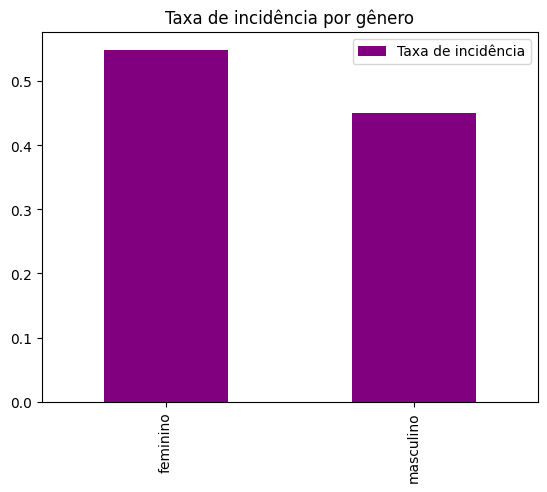

In [96]:
dfIncPorGen = pd.DataFrame([['feminino', perc_mulher],['masculino', perc_homem]], columns=['Gênero', 'Taxa de incidência'])
dfIncPorGen.plot(x='Gênero', y='Taxa de incidência', kind='bar', title='Taxa de incidência por gênero', color='purple', xlabel='')
plt.show()

Podemos nos perguntar também se existe uma taxa de mortalidade diferente para cada gênero

In [97]:
n_obt_fem = df[(df['Genero'].str.lower().str.strip()=='feminino')&(df['Obito'].str.strip()=='1')].shape[0]
n_obt_masc = df[(df['Genero'].str.lower().str.strip()=='masculino')&(df['Obito'].str.strip()=='1')].shape[0]
n_obt_nid = df[(df['Genero'].str.lower().str.strip()!='masculino')&(df['Genero'].str.lower().str.strip()!='feminino')&(df['Obito'].str.strip()=='1')].shape[0]


perc_mulher = n_obt_fem/n_inc_fem
perc_homem = n_obt_masc/n_inc_masc
perc_naoid = n_obt_nid/n_total_pessoas

print(f"O percentual de obitos por genero é de:\n\nMulher: {perc_mulher:.3%}\nHomem: {perc_homem:.3%}\nNão identificado na população total: {perc_naoid:.3%}")

O percentual de obitos por genero é de:

Mulher: 2.221%
Homem: 3.473%
Não identificado na população total: 0.000%


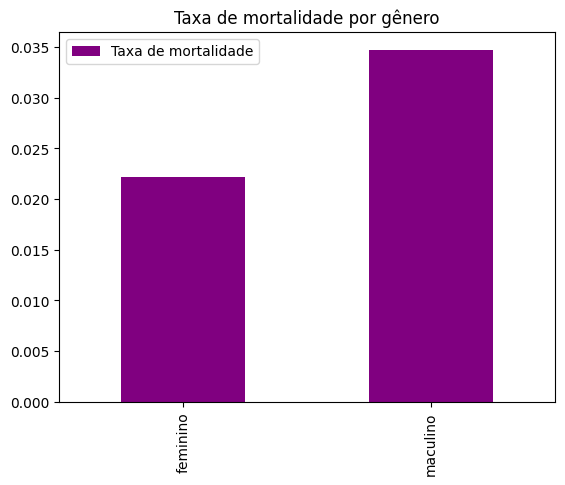

In [98]:
dfMortPorGen = pd.DataFrame([['feminino', perc_mulher],['maculino', perc_homem]], columns=['Gênero', 'Taxa de mortalidade'])
dfMortPorGen.plot(x='Gênero', y='Taxa de mortalidade', kind='bar', title='Taxa de mortalidade por gênero', color='purple', xlabel='')
plt.show()

Pela frequência de casos de covid-19 por gênero, podemos ver que há uma diferença significativa de 10% nos casos entre o gênero masculino e feminino, sendo as mulheres com a maior taxa de incidência. Mesmo assim, vemos que a taxa de mortalidade é maior para o gênero masculino, com uma diferença maior que 1%

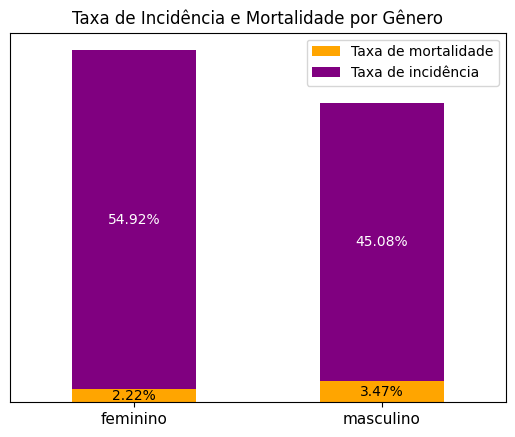

In [99]:
perc_inc_fem = dfIncPorGen.loc[dfMortPorGen['Gênero']=='feminino', 'Taxa de incidência'].values[0]
perc_inc_masc = dfIncPorGen.loc[dfMortPorGen['Gênero']=='maculino', 'Taxa de incidência'].values[0]
perc_mort_fem = dfMortPorGen.loc[dfMortPorGen['Gênero']=='feminino', 'Taxa de mortalidade'].values[0]
perc_mort_masc = dfMortPorGen.loc[dfMortPorGen['Gênero']=='maculino', 'Taxa de mortalidade'].values[0]
# Combinar incidência e mortalidade em um único dataframe
df_combined = pd.DataFrame({
    'Gênero': ['feminino', 'masculino'],
    'Taxa de incidência': [perc_inc_fem, perc_inc_masc],
    'Taxa de mortalidade': [perc_mort_fem, perc_mort_masc]
})

ax = df_combined.plot(x='Gênero', y=['Taxa de mortalidade', 'Taxa de incidência'], kind='bar', stacked=True, title='Taxa de Incidência e Mortalidade (base) por Gênero', xlabel='', ylabel='', color=['orange','purple'])
plt.xticks(rotation=0, fontsize=11)
plt.yticks([])
plt.title('Taxa de Incidência e Mortalidade por Gênero', fontsize=12)

# Adiciona valores numéricos às barras
for i, c in enumerate(ax.containers):
    labels = [f'{w:.2%}' if (w := v.get_height()) > 0 else '' for v in c]
    if i == 0:
        ax.bar_label(c, labels=labels, label_type='center', color= 'black')
    else:
      ax.bar_label(c, labels=labels, label_type='center', color= 'white')

plt.show()

# Pergunta 2:

 Faça um gráfico da mortalidade por faixas de idade

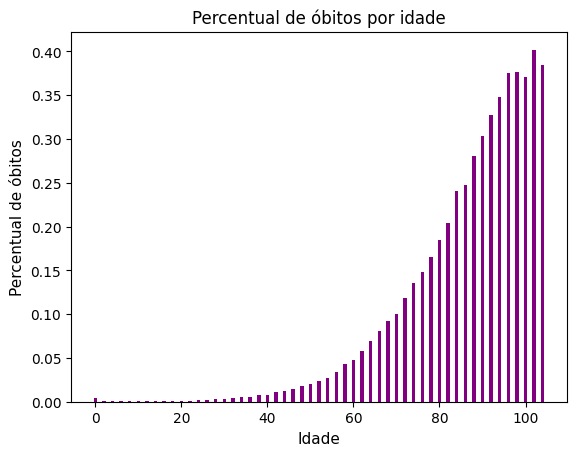

In [100]:
df_mortos = df[df['Obito'].str.strip()=='1']
df_mortosAux = pd.DataFrame(df_mortos['Idade'].value_counts()).reset_index()
df_mortosAux.columns = ['Idade', 'N_Obitos'] # DataFrame com o número de pessoas que vieram a óbito por idade

df_Aux = pd.DataFrame(df['Idade'].value_counts()).reset_index()
df_Aux.columns = ['Idade', 'N_Casos'] # DataFrame com a incidência de COVID por idade

dfPlot = pd.merge(df_mortosAux, df_Aux, on='Idade', how='left')
dfPlot['perc'] = dfPlot['N_Obitos']/dfPlot['N_Casos'] # DataFrame com a porcentagem de obitos por idade (N_Obitos/N_Casos)
dfPlot['Idade'] = dfPlot['Idade'].astype(float)
dfPlot.sort_values(by='Idade', ascending=True, inplace=True)
dfBar = dfPlot.iloc[:-7:2]

plt.bar(dfBar['Idade'], dfBar['perc'], color='purple')
plt.title('Percentual de óbitos por idade', fontsize=12)
plt.ylabel('Percentual de óbitos', fontsize=11)
plt.xlabel('Idade', fontsize=11)
plt.show()

Observa-se que a curva do percentual de óbitos por idade lembra uma curva exponencial, de tão significativo que é esse parâmetro. Até os 50 anos, essa taxa é de menos de 5% (um crescimento de 5% em um intervalo de 50 anos), porém entre 60 e 100 anos, esse percentual cresce rápidamente até 40% (um crescimento de 35% em um intervalo menor, de 40 anos).

# Pergunta 3:

Qual a doença pré-existente mais provável de se encontrar numa pessoa com covid?

Aqui é importante nota nos dado que existem muitas linhas que não possuem registro de doenças pre-existentes, por isso utilizaremos o DataFrame "df_new".


In [219]:
df_new.head()

,Asma,Cardiopatia,Diabetes,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca_Renal,Genero,Idade,Imunodepressao,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
4681,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,MASCULINO,82.0,NÃO,NÃO,1,SIM,NÃO,NÃO,NÃO
4682,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,FEMININO,30.0,NÃO,SIM,1,NÃO,NÃO,NÃO,NÃO
4683,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,MASCULINO,32.0,NÃO,NÃO,1,SIM,NÃO,NÃO,NÃO
4684,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,MASCULINO,69.0,NÃO,NÃO,0,SIM,NÃO,NÃO,NÃO
4685,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,MASCULINO,78.0,NÃO,NÃO,1,SIM,NÃO,NÃO,NÃO


In [110]:
data = []
n_total_pessoas = df_new.shape[0]
i=0
for doenca in doencas:
    df_new_doenca = df_new[(df_new[doenca]=='SIM')] # Para cada doença, cria um DataFrame apenas de pessoas que possuem essa doença e vieram a óbito
    n_doenca = df_new_doenca.shape[0] # N de pessoas com essa doença que vieram a óbito
    prob_doenca = n_doenca/n_total_pessoas # Prob de vir a óbito tendo a doença (n_doenca/n_total_pessoas_obito)
    data.append([doenca, prob_doenca])
    i+=1

df_prob_covid_por_doenca = pd.DataFrame(data, columns=['Doenca', 'Probabilidade'])
df_prob_covid_por_doenca.sort_values(by='Probabilidade', ascending=False, inplace=True)
print(df_prob_covid_por_doenca)

                     Doenca  Probabilidade
1               Cardiopatia       0.550786
9   Outros_Fatores_De_Risco       0.403652
2                  Diabetes       0.373935
8                 Obesidade       0.139382
5        Doenca_Neurologica       0.065770
6              Doenca_Renal       0.054647
10              Pneumopatia       0.052594
0                      Asma       0.043189
7            Imunodepressao       0.040001
4           Doenca_Hepatica       0.013087
3       Doenca_Hematologica       0.012366
11                 Puérpera       0.005236
12         Síndrome_De_Down       0.004239


Vemos que a Cardiopatia é a doença que mais domina em nosso dataset, tendo quase 55% de frequência na população. Podemos nos perguntar também qual é a taxa de mortalidade por doença

In [111]:
data = []
n_total_pessoas_obito = df_new[df_new['Obito']=='1'].shape[0]
i=0
for doenca in doencas:
    df_new_doenca = df_new[(df_new[doenca]=='SIM')&(df_new['Obito']=='1')] # Para cada doença, cria um DataFrame apenas de pessoas que possuem essa doença e vieram a óbito
    n_doenca = df_new_doenca.shape[0] # N de pessoas com essa doença que vieram a óbito
    prob_doenca = n_doenca/n_total_pessoas_obito # Prob de vir a óbito tendo a doença (n_doenca/n_total_pessoas_obito)
    data.append([doenca, prob_doenca])
    i+=1

df_prob_covid_por_doenca = pd.DataFrame(data, columns=['Doenca', 'Probabilidade'])
df_prob_covid_por_doenca.sort_values(by='Probabilidade', ascending=False, inplace=True)
print(df_prob_covid_por_doenca)

                     Doenca  Probabilidade
1               Cardiopatia       0.593693
9   Outros_Fatores_De_Risco       0.414889
2                  Diabetes       0.410522
8                 Obesidade       0.143972
5        Doenca_Neurologica       0.087774
6              Doenca_Renal       0.077166
10              Pneumopatia       0.069488
7            Imunodepressao       0.046727
0                      Asma       0.031425
4           Doenca_Hepatica       0.017204
3       Doenca_Hematologica       0.013509
12         Síndrome_De_Down       0.003914
11                 Puérpera       0.002532


Onde vemos que a doença pré-existente mais provável de se encontrar em uma pessoa que veio a óbito por covid é a Cardiopatia. Isso mostra um risco extremamente grande para a população, pois a doença com maior taxa de mortalidade é justamente a doença mais comum de se encontrar.

A pergunta que podemos fazer também é a relação entre essas doenças e a idade das pessoas.

In [112]:
top_3_doencas = df_prob_covid_por_doenca.head(3)['Doenca'].tolist()
bottom_3_doencas = df_prob_covid_por_doenca.tail(3)['Doenca'].tolist()
print(f"As 3 doenças pré-existentes mais prováveis de se encontrar em pessoas que vieram a óbito por COVID-19 são: \n{top_3_doencas}")
print(f"As 3 doenças pré-existentes menos prováveis de se encontrar em pessoas que vieram a óbito por COVID-19 são: \n{bottom_3_doencas}")

As 3 doenças pré-existentes mais prováveis de se encontrar em pessoas que vieram a óbito por COVID-19 são: 
['Cardiopatia', 'Outros_Fatores_De_Risco', 'Diabetes']
As 3 doenças pré-existentes menos prováveis de se encontrar em pessoas que vieram a óbito por COVID-19 são: 
['Doenca_Hematologica', 'Síndrome_De_Down', 'Puérpera']


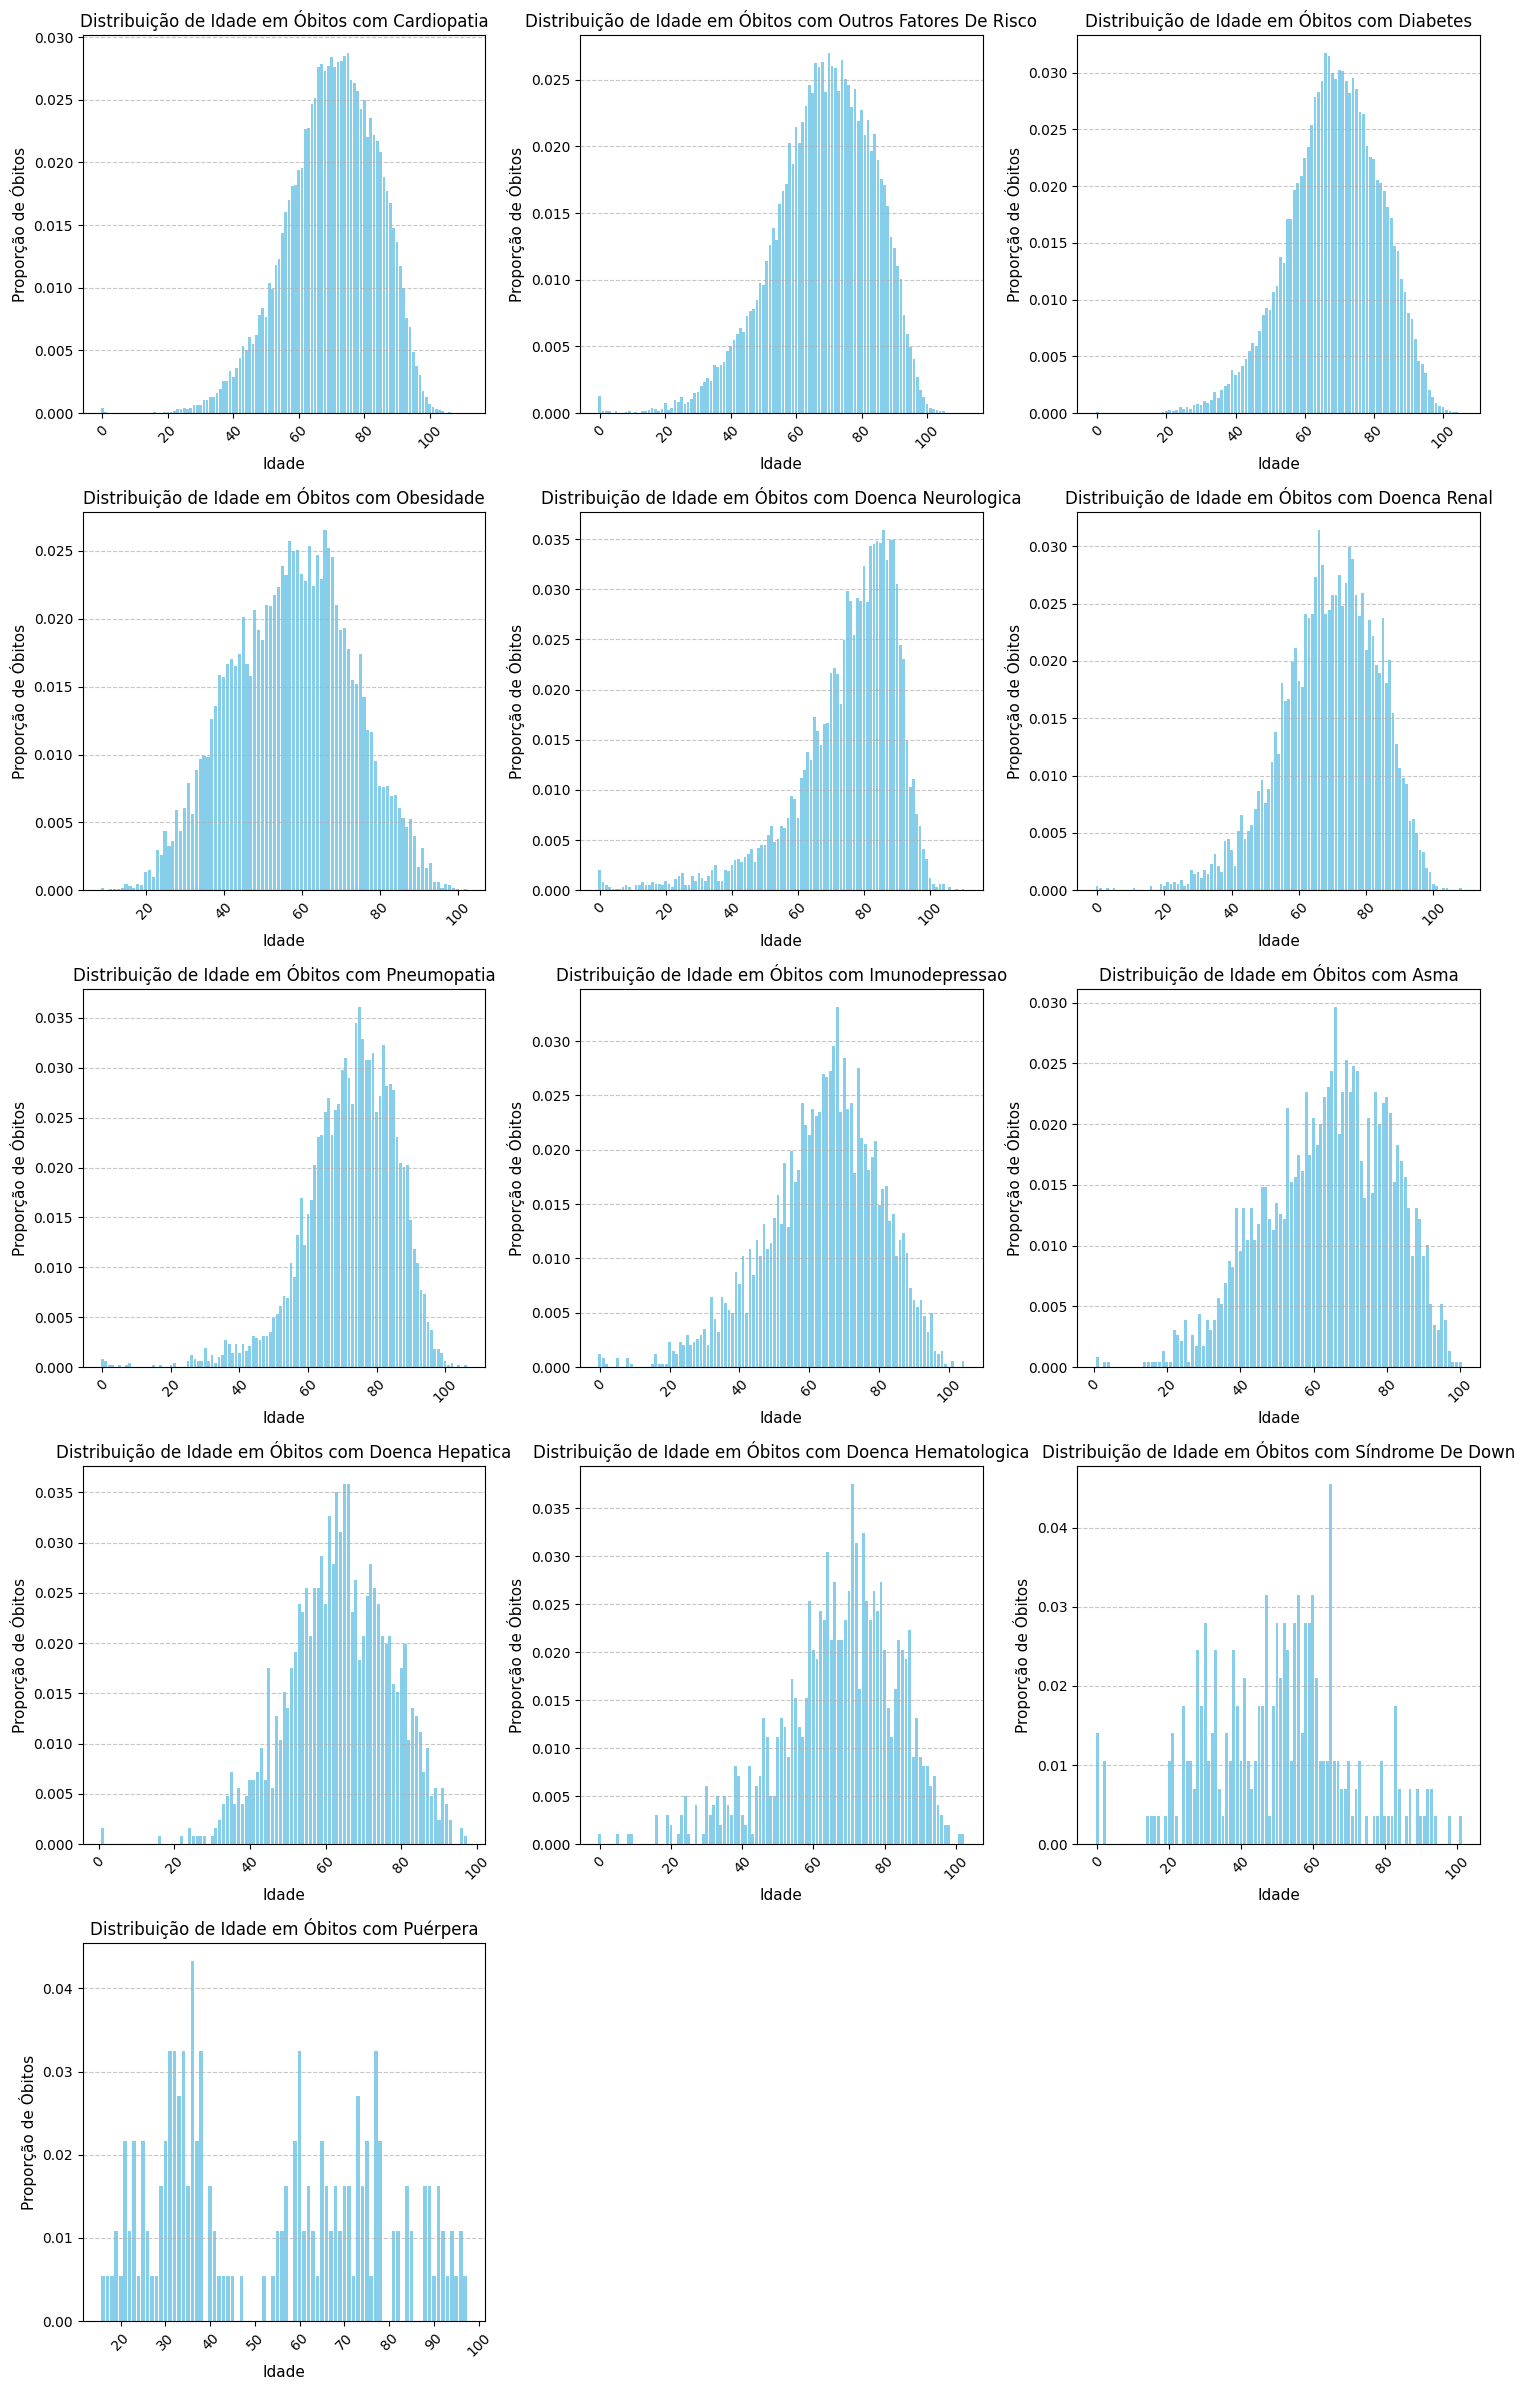

In [113]:
doencas = df_prob_covid_por_doenca['Doenca'].tolist()
df_mortos = df_new[df_new['Obito'] == '1']

plt.figure(figsize=(15, 24))

for i, doenca in enumerate(doencas):
    # Filter for deaths with the specific disease
    df_doenca_mortos_idade = df_mortos[(df_mortos[doenca].str.upper().str.strip() == 'SIM') & (df_mortos['Idade'].notna())]

    # Calculate age distribution for this disease
    age_distribution = df_doenca_mortos_idade['Idade'].astype(float).value_counts(normalize=True).sort_index()

    plt.subplot(5, 3, i + 1)
    plt.bar(age_distribution.index, age_distribution.values, color='skyblue')
    plt.title(f'Distribuição de Idade em Óbitos com {doenca.replace("_", " ")}', fontsize=12)
    plt.xlabel('Idade', fontsize=11)
    plt.ylabel('Proporção de Óbitos', fontsize=11)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


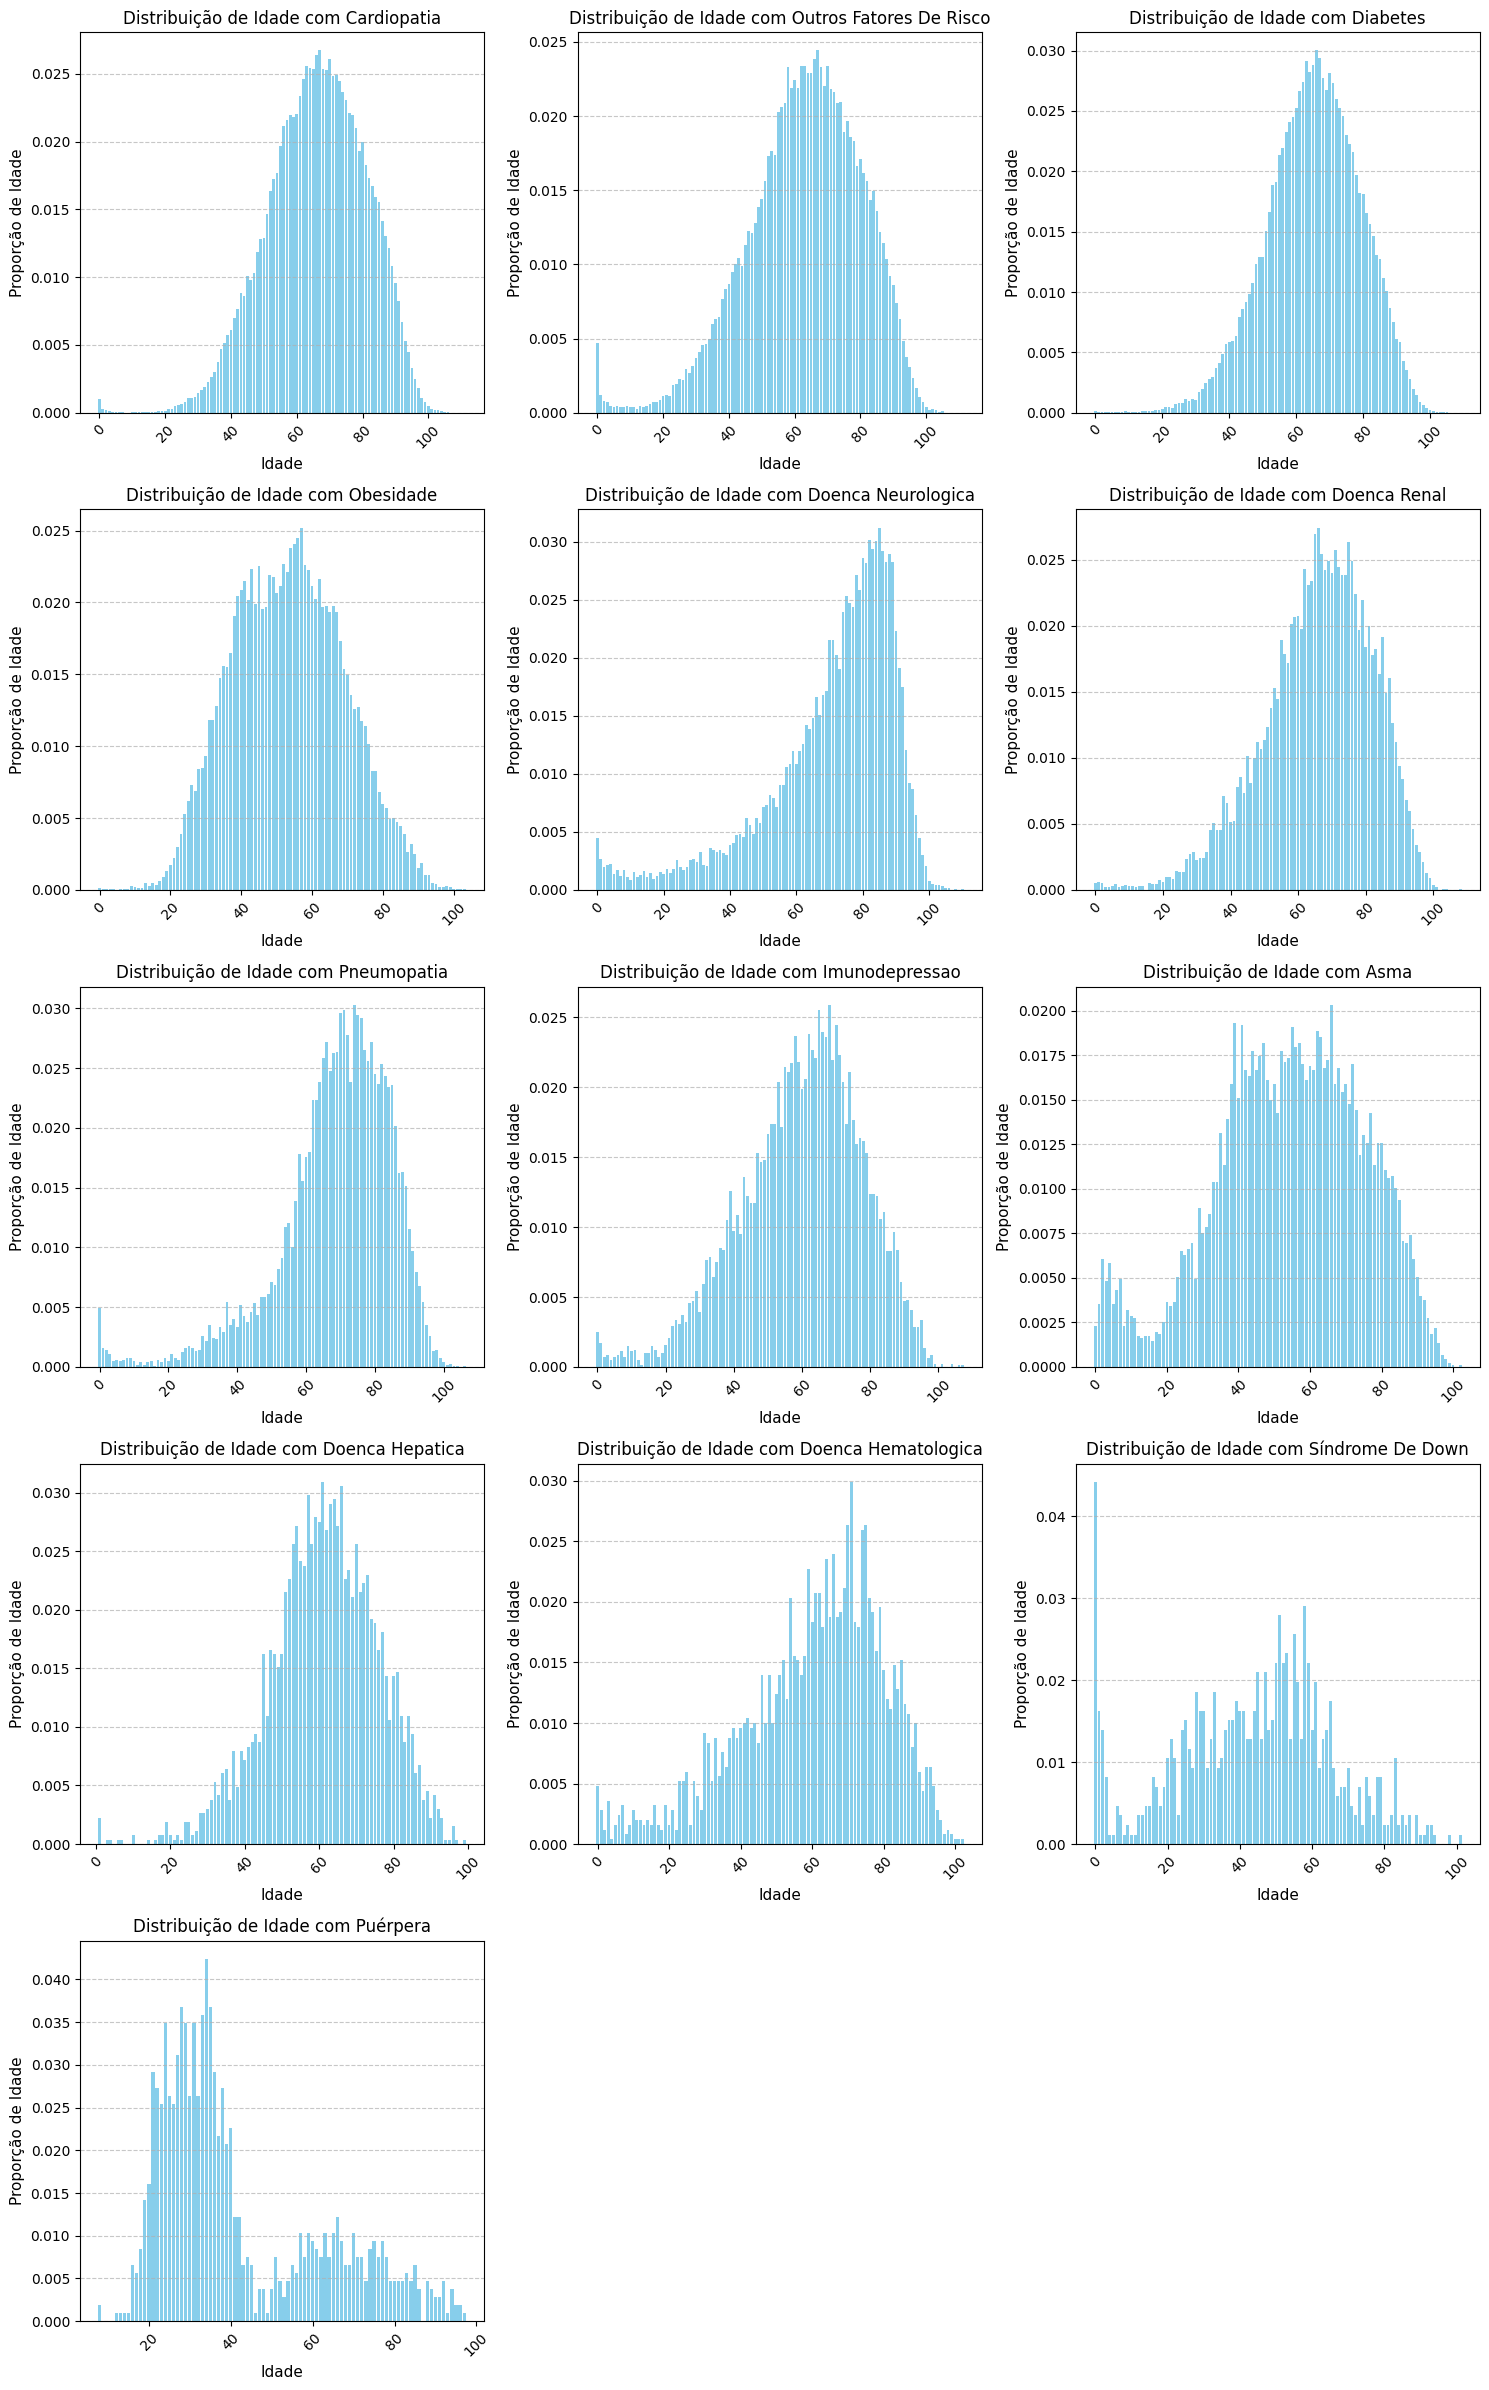

In [114]:
doencas = df_prob_covid_por_doenca['Doenca'].tolist()

plt.figure(figsize=(15, 24))

for i, doenca in enumerate(doencas):
    # Filter for deaths with the specific disease
    df_doenca_idade = df_new[(df_new[doenca].str.upper().str.strip() == 'SIM') & (df_new['Idade'].notna())]

    # Calculate age distribution for this disease
    age_distribution = df_doenca_idade['Idade'].astype(float).value_counts(normalize=True).sort_index()

    plt.subplot(5, 3, i + 1)
    plt.bar(age_distribution.index, age_distribution.values, color='skyblue')
    plt.title(f'Distribuição de Idade com {doenca.replace("_", " ")}', fontsize=12)
    plt.xlabel('Idade', fontsize=11)
    plt.ylabel('Proporção de Idade', fontsize=11)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Abaixo podemos ver que um gráfico boxplot da distribuição de idade de pessoas que vieram a óbito e possuiam certa doença pré-existente em comparação com a distribuição de idade da doença em toda a população.

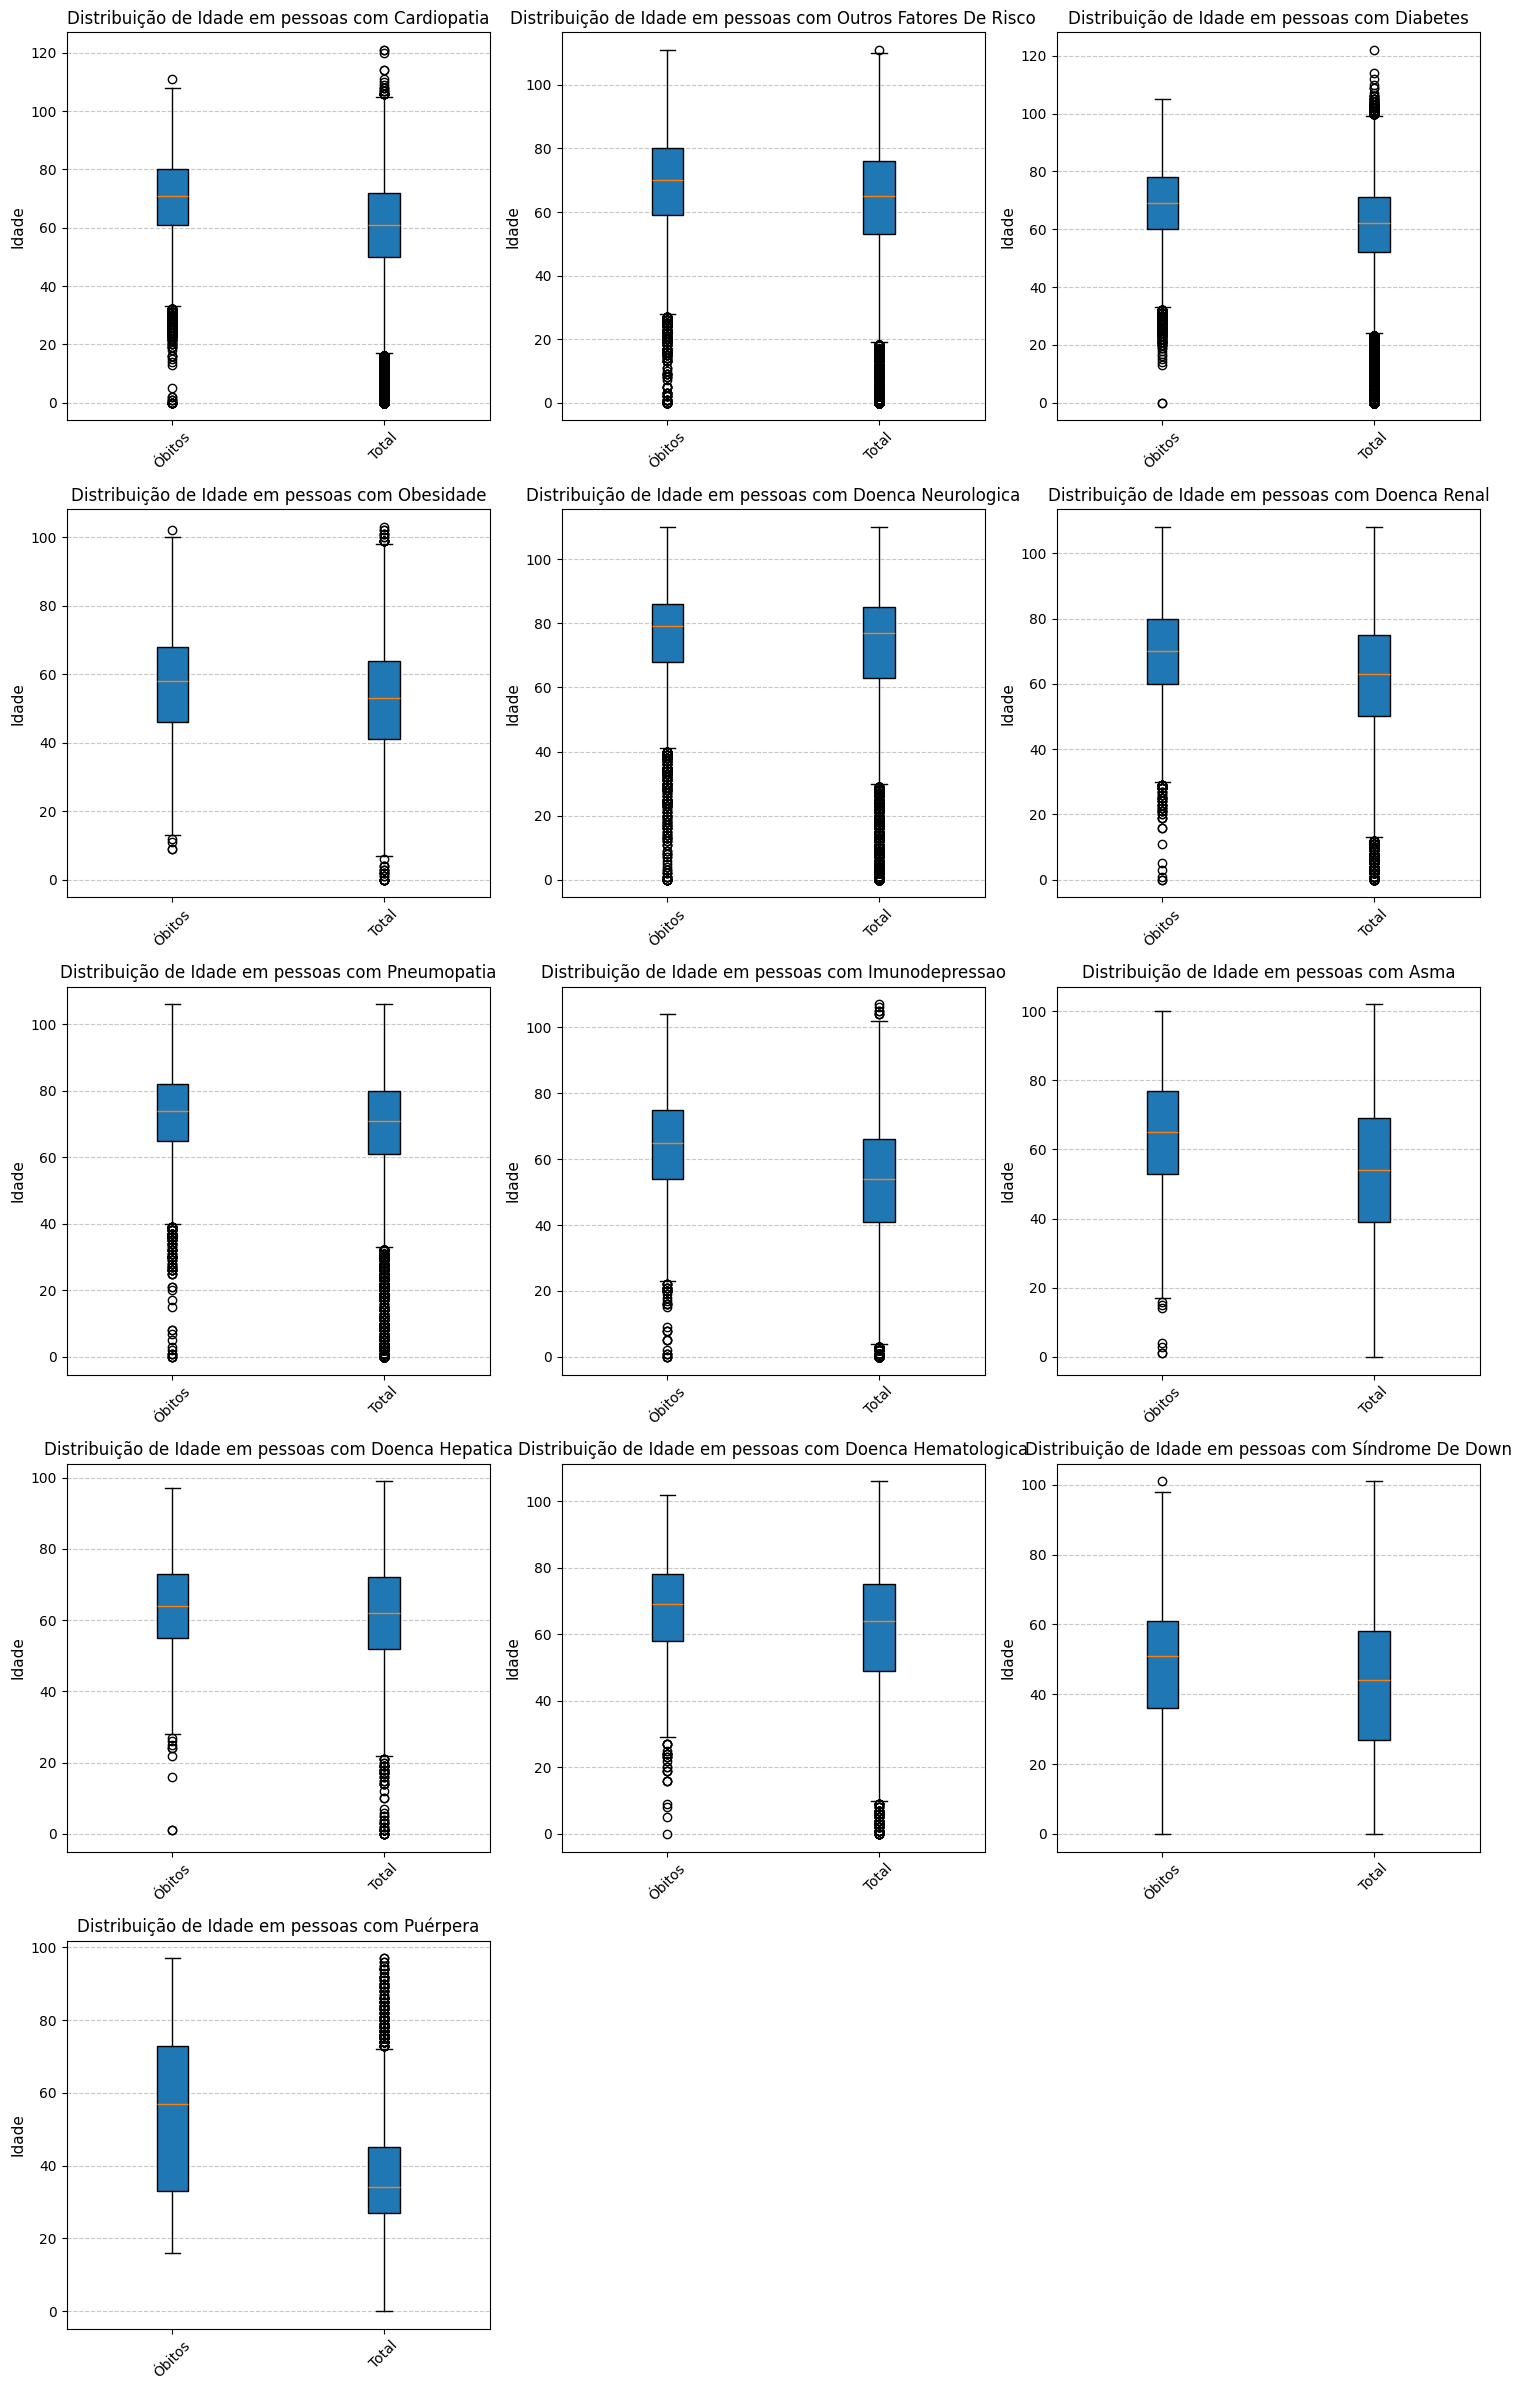

In [115]:
doencas = df_prob_covid_por_doenca['Doenca'].tolist()
df_mortos = df_new[df_new['Obito'] == '1']

plt.figure(figsize=(15, 24))

for i, doenca in enumerate(doencas):
    # Filter for deaths with the specific disease
    df_doenca_mortos_idade = df_mortos[(df_mortos[doenca] == 'SIM') & (df_mortos['Idade'].notna())]
    df_doenca_idade = df[(df[doenca] == 'SIM') & (df['Idade'].notna())]
    data1 = df_doenca_mortos_idade['Idade'].astype(float)
    data2 = df_doenca_idade['Idade'].astype(float)

    # Calculate age distribution for this disease
    '''age_distribution = df_doenca_mortos_idade['Idade'].astype(float).value_counts(normalize=True).sort_index()
    print(age_distribution)'''

    plt.subplot(5, 3, i + 1)
    plt.boxplot([data1, data2], vert=True, patch_artist=True, tick_labels=['Óbitos', 'Total'])
    plt.title(f'Distribuição de Idade em pessoas com {doenca.replace("_", " ")}', fontsize=12)
    plt.ylabel('Idade', fontsize=11)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


É interessante perceber que a mediana (linha laranja dentro da caixa) do subconjunto de óbitos é sempre maior que o conjunto total da população, ou seja, dentre a população de pessoas que possuem certa comorbidade, aquelas que morrem são sempre as mais velhas. Além disso, os pontos "outliers" no subconjunto de dados são quase sempre os pontos com idade menor do que a caixa.

Essas diferenças evidenciam ainda mais a importância da idade na análise.

# Pergunta 4:

Baseado nesses dados, faça um modelo que estime a probabilidade da pessoa morrer, uma vez que está contaminada com covid, e considerando os inputs de idade, gênero e doenças pré-existentes

## MODELO BAYESIANO

Pelo teorema de Bayes:

$P(X|\bigcap_{i}^{n}Y_i,I) = \frac{P(\bigcap_{i}^{n}Y_i|X,I)\times P(X|I)}{P(\bigcap_{i}^{n}Y_i|I)}$

Se pensarmos em X como nossa hipótese "Morrer por COVID19", em I como a constatação "A pessoa está contaminada com COVID19" e em Y como nossos inputs de dados: Idade, Gênero e Doenças pré-existentes, podemos montar um modelo bayesiano para prever a probabilidade de uma pessoa morrer de covid, basta ser possível calcularmos as funções relacionadas.

***

*Prior probability function* = $P(X|I)$

A probabilidade de alguém morrer de covid a priori dado que está com covid, calculada como a frequência com que as pessoas morrem de covid dado que estão contaminadas (nosso espaço amostral).

***

*Data probability* = $P(\bigcap_{i}^{n}Y_i|I) = P(Y_1 ⋂ Y_2 ⋂ ... ⋂ Y_n|I)$

Note que $P(Y_1 ⋂ Y_2 ⋂ ... ⋂ Y_n|I) = P(Y_1|I)*P(Y_2|Y_1,I)*...*P(Y_n|Y_{n-1}⋂Y_{n-2}⋂...⋂Y_1,I)$

Aqui temos a probabilidade dos inputs dado que a pessoa está contaminada, ou seja, a probabilidade da pessoa ter x anos, ser de tal gênero e possuir as n-2 doenças existentes dado que ela está contaminada. Essa probabilidade é calculada como sendo a frequência de ocorrência dessa combinação de inputs em todo o espaço amostral. Caso não haja nenhuma ocorrência, não é possível cacular a probabilidade de óbito (essa ocorrência nunca aconteceu, então o modelo não é capaz de prever o resultado).

***

*Likelihood probability function* = $P( \bigcap_{i}^{n} Y_i|X,I)=P(Y_1 ⋂ Y_2 ⋂ ... ⋂ Y_n|X,I)$

Note que $P(Y_1 ⋂ Y_2 ⋂ ... ⋂ Y_n|X,I) = P(Y_1|X,I)*P(Y_2|Y_1,X,I)*...*P(Y_n|Y_{n-1}⋂Y_{n-2}⋂...⋂Y_1,X,I)$

A probabilidade de alguém ter os inputs dado que ela morreu de covid e estava contaminada. Utilizaremos a frequência da combinação de inputs dado que a pessoa morreu de covid-19, ou seja, dentro do subespaço de óbitos dentro de nosso espaço amostral, ao invés do espaço amostral inteiro, como no caso da "Data probability". Caso esse valor seja zero, mas haja ocorrência no espaço amostral, então a probabilidade de óbito será zero (apesar de ter ocorrência no espaço amostral, ninguém foi a óbito).

Você pode criar uma linha horizontal usando três ou mais hífens (`---`), asteriscos (`***`), ou underscores (`___`).

Por exemplo, digite o seguinte:

---

ou

***

ou

___

O resultado será uma linha horizontal como esta:

---

In [225]:
import warnings
import pandas as pd

# Desativando erros do pandas
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', message='A value is trying to be set on a copy of a slice from a DataFrame.')


def obito_por_covid_priori(dataframe):
    '''
    A probabilidade a priori P(X|I) de um evento X acontecer, dado o conjunto de dados, no caso, ter covid.
    '''

    print(f"\nCALCULANDO A PROBABILIDADE A PRIORI DE MORRER POR COVID19...\n")

    obitos = dataframe[dataframe['Obito']=='1'].shape[0]
    populacao = dataframe.shape[0]
    prob_obito = obitos/populacao

    print(f"A probabilidade a priori de morrer por covid é: {prob_obito:.6%}")

    return prob_obito

def likelihood_function(dados, dataframe):

    print(f"\nCALCULANDO A FUNÇÃO LIKELIHOOD...\n")

    idade = int(dados[0])
    genero = str(dados[1]).upper()
    try: doencas_preexistentes = [str(x) for x in dados[2:]]
    except: doencas_preexistentes = []
    print(f"A idade é: {idade}")
    print(f"O gênero é: {genero}")
    print(f"As doenças pré-existentes são: {doencas_preexistentes}")

    df = dataframe.copy()

    prob=1

    df_mortos = df[df['Obito']=='1']
    n_mortos = df_mortos.shape[0]

    df_mortos = df_mortos[df_mortos['Idade']==idade]
    n_mortos_idade = df_mortos.shape[0]
    prob *= n_mortos_idade/n_mortos

    df_mortos = df_mortos[df_mortos['Genero']==genero]
    n_mortos_genero_idade = df_mortos.shape[0]
    prob *= n_mortos_genero_idade/n_mortos_idade

    for doenca in doencas_preexistentes:
        n = df_mortos.shape[0]
        df_mortos = df_mortos[df_mortos[doenca]=='SIM']
        prob *= df_mortos.shape[0]/n

    print(f"A probabilidade likelihood é de {prob:.6%}")

    return prob

def data_probability(dados,dataframe):
    '''
    A probabilidade dos dados, ou seja, a probabilidade da pessoa ter x anos, ser de tal gênero e possuir as n doenças existentes.
    '''
    print(f"\nCALCULANDO A PROBABILIDADE DOS DADOS...\n")

    idade = float(dados[0])
    genero = str(dados[1])
    try: doencas_preexistentes = [str(x) for x in dados[2:]]
    except: doencas_preexistentes = []

    df = dataframe.copy()
    n = df.shape[0]

    prob=1

    df = df[df['Idade']==idade]
    n_idade = df.shape[0]
    prob *= n_idade/n

    if n_idade == 0:
      return 0

    else:

      df = df[df['Genero']==genero]
      n_genero_idade = df.shape[0]
      prob *= n_genero_idade/n_idade

      for doenca in doencas_preexistentes:
          n = df.shape[0]
          df = df[df[doenca]=='SIM']
          prob *= df.shape[0]/n

      print(f"A probabilidade dos dados é de {prob:.6%}")

      return prob

def prob_obito(dados,df):
    '''
    A probabilidade de uma pessoa morrer de covid dado a sua idade, gênero e doenças pré-existentes.
    '''

    prior_prob = obito_por_covid_priori(df)
    data_prob = data_probability(dados,df)

    if data_prob == 0:
      print(f'Não há dados suficientes para calcular a probabilidade para o conjunto de entrada')
      return None
    else:
      likelihood_prob = likelihood_function(dados,df)
      return prior_prob*likelihood_prob/data_prob

Para descobrir qual seria a probabilidade de você morrer dado sua idade, gênero e doenças pré-existentes, basta rodar a célula abaixo.

In [227]:
def main():

    idade = int(input(f"Qual a sua idade?: "))
    genero = str(input(f"Qual o seu gênero (M/F)?: "))
    if genero =='M' or genero=='m': genero = 'MASCULINO'
    elif genero == 'F' or genero=='f': genero = 'FEMININO'

    doencas = str(input(f"Escreva quais dessas doenças pré-existentes você possui (separe as doenças por ponto e vírgula): \n \
Asma, Cardiopatia, Diabetes, Doenca_Hematologica, Doenca_Hepatica, Doenca_Neurologica, Doenca_Renal, \n \
Imunodepressao, Obesidade, Pneumopatia, Puérpera ou Síndrome_De_Down\n"))

    if doencas == '':
        dados = [idade, genero]
    else:
        dados = [idade, genero]
        for doenca in doencas.split(';'):
            doenca = doenca.strip()
            dados.append(doenca)

    result = prob_obito(dados, df_new)
    if result != None:
      print(f"\nA probabilidade de você morrer de covid é de {result:.6%}")

    return None

if __name__ == "__main__":
    main()

Qual a sua idade?: 20
Qual o seu gênero (M/F)?: F
Escreva quais dessas doenças pré-existentes você possui (separe as doenças por ponto e vírgula): 
 Asma, Cardiopatia, Diabetes, Doenca_Hematologica, Doenca_Hepatica, Doenca_Neurologica, Doenca_Renal, 
 Imunodepressao, Obesidade, Pneumopatia, Puérpera ou Síndrome_De_Down
Obesidade

CALCULANDO A PROBABILIDADE A PRIORI DE MORRER POR COVID19...

A probabilidade a priori de morrer por covid é: 36.054677%

CALCULANDO A PROBABILIDADE DOS DADOS...

A probabilidade dos dados é de 0.012830%

CALCULANDO A FUNÇÃO LIKELIHOOD...

A idade é: 20
O gênero é: FEMININO
As doenças pré-existentes são: ['Obesidade']
A probabilidade likelihood é de 0.010949%

A probabilidade de você morrer de covid é de 30.769231%
